In [22]:
import scanpy as sc
import pandas
import anndata as ad
import scvi
import numpy
import subprocess
import sys
import importlib
import rpy2.robjects
readRDS = rpy2.robjects.r['readRDS']
saveRDS= rpy2.robjects.r["saveRDS"]
import os
from rpy2.robjects import pandas2ri
import scipy
from scipy.sparse import csr_matrix
pandas2ri.activate()

def get_ref_counts_df() :
    l_df = []
    for name in ['ref_sc_peng','ref_sc_baron','ref_sc_raghavan'] :
        # file = "data/"+name+".mtx"
        file = "attachement/"+ name+".rds"
        r_data = readRDS(file)
        df = pandas.DataFrame( numpy.transpose(  numpy.vstack([r_data[i] for i in range(len(r_data))]) )  , index =r_data.slots["row.names"],columns= r_data.slots["names"] )
        l_df.append(df)
    return l_df
    # return (l_df[0],l_df[1],l_df[2])

In [23]:
# Read data

metadata_path = "./attachement"
meta_peng = pandas.read_csv(os.path.join(metadata_path, "peng_metadata.csv"), index_col=0, sep=";")
meta_peng['dataset'] = ["peng"]*meta_peng.shape[0]
meta_baron = pandas.read_csv(os.path.join(metadata_path, "baron_metadata.csv"), index_col=0, sep=";")
meta_baron.index = meta_baron.index.str.replace("-",".")
meta_baron['dataset'] = ["baron"]*meta_baron.shape[0]
meta_raghavan = pandas.read_csv(os.path.join(metadata_path, "raghavan_metadata.csv"), index_col=0, sep=";")
meta_raghavan['dataset'] = ["raghavan"]*meta_raghavan.shape[0]
(df_counts_peng,df_counts_baron,df_counts_raghavan) = get_ref_counts_df()


sc_pen = ad.AnnData(X= df_counts_peng.T, obs=meta_peng)
sc_baron = ad.AnnData(X= df_counts_baron.T, obs=meta_baron)
sc_raghavan = ad.AnnData(X= df_counts_raghavan.T, obs=meta_raghavan)


In [ ]:
def create_pseudo_bulk(anndata, groupby, method='sum'):
    """
    Create pseudo-bulk data from a single-cell AnnData object.

    Parameters:
        anndata: AnnData
            Single-cell AnnData object.
        groupby: str
            Column in `anndata.obs` used to group cells.
        method: str
            Aggregation method ('sum' or 'mean'). Default is 'sum'.
    
    Returns:
        pseudo_bulk_matrix: pd.DataFrame
            Pseudo-bulk expression matrix with groups as rows and genes as columns.
    """

    # Ensure the groupby column exists in `anndata.obs`
    if groupby not in anndata.obs.columns:
        raise ValueError(f"'{groupby}' is not a column in anndata.obs")
    
    # Convert sparse matrix to dense if necessary
    X = anndata.X
    if isinstance(X, csr_matrix):
        X = X.toarray()
    
    # Group by the specified column
    groups = anndata.obs[groupby]
    unique_groups = groups.unique()

    # Create an empty DataFrame to store pseudo-bulk data
    pseudo_bulk_data = []
    group_names = []

    for group in unique_groups:
        # Find cells in the current group
        group_mask = groups == group
        group_data = X[group_mask, :]
        
        # Aggregate expression values
        if method == 'sum':
            aggregated = group_data.sum(axis=0)
        elif method == 'mean':
            aggregated = group_data.mean(axis=0)
        else:
            raise ValueError(f"Unsupported method '{method}'. Use 'sum' or 'mean'.")
        
        pseudo_bulk_data.append(aggregated)
        group_names.append(group)

    # Create a DataFrame for the pseudo-bulk matrix
    pseudo_bulk_matrix = pandas.DataFrame(
        numpy.vstack(pseudo_bulk_data),
        index=group_names,
        columns=anndata.var_names
    )
    
    return pseudo_bulk_matrix


    

In [ ]:
# create and save pseudo bulk data

pseudo_bulk_pen_sum = create_pseudo_bulk(sc_pen, groupby="cell_type", method='sum').T
pseudo_bulk_baron_sum = create_pseudo_bulk(sc_baron, groupby="cell_type", method='sum').T
pseudo_bulk_raghavan_sum = create_pseudo_bulk(sc_raghavan, groupby="cell_type", method='sum').T

pseudo_bulk_pen_sum.to_csv("peng_pseudo_bulk_sum.csv")
pseudo_bulk_baron_sum.to_csv("baron_pseudo_bulk_sum.csv")
pseudo_bulk_raghavan_sum.to_csv("raghavan_pseudo_bulk_sum.csv")



In [ ]:
from inmoose.pycombat.pycombat_seq import pycombat_seq
from inmoose.edgepy import DGEList, glmLRT, topTags

#intersect gene list sc rnaseq
# merge metadata
meta_3sc = pandas.concat([meta_peng, meta_baron, meta_raghavan], axis=0)
gene_intersection = numpy.intersect1d(numpy.intersect1d(df_counts_peng.index, df_counts_baron.index), df_counts_raghavan.index)
count_3sc = pandas.concat([df_counts_peng.loc[gene_intersection], df_counts_baron.loc[gene_intersection], df_counts_raghavan.loc[gene_intersection]], axis=1)

single_cell_batch_corrected = pycombat_seq(count_3sc,batch=meta_3sc["dataset"].values,covar_mod=meta_3sc["cell_type"].values)

In [ ]:
# sc-rna processing and getting variable genes

def pre_get_variable_gene(adata):
    """Pre-process single cell data and perform differential expression analysis

    Parameters:
        adata: AnnData
            Single-cell AnnData object
    """
    sc.pp.filter_genes(adata, min_cells=20)
    sc.pp.filter_cells(adata, min_genes=3)

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="sample")


    if "cell_type" in adata.obs.columns:
            sc.tl.rank_genes_groups(
                adata,
                "cell_type",
                method="wilcoxon",
                key_added="wilcoxon_cell_type",
                use_raw=False,
            )

    return adata

In [30]:
# Read data

metadata_path = "./attachement"
meta_peng = pandas.read_csv(os.path.join(metadata_path, "peng_metadata.csv"), index_col=0, sep=";")
meta_peng['dataset'] = ["peng"]*meta_peng.shape[0]
meta_baron = pandas.read_csv(os.path.join(metadata_path, "baron_metadata.csv"), index_col=0, sep=";")
meta_baron.index = meta_baron.index.str.replace("-",".")
meta_baron['dataset'] = ["baron"]*meta_baron.shape[0]
meta_raghavan = pandas.read_csv(os.path.join(metadata_path, "raghavan_metadata.csv"), index_col=0, sep=";")
meta_raghavan['dataset'] = ["raghavan"]*meta_raghavan.shape[0]
(df_counts_peng,df_counts_baron,df_counts_raghavan) = get_ref_counts_df()


sc_pen = ad.AnnData(X= df_counts_peng.T, obs=meta_peng)
sc_baron = ad.AnnData(X= df_counts_baron.T, obs=meta_baron)
sc_raghavan = ad.AnnData(X= df_counts_raghavan.T, obs=meta_raghavan)

# Pre-process single-cell data

sc_pen_processed = pre_get_variable_gene(sc_pen)
sc_baron_processed = pre_get_variable_gene(sc_baron)
sc_raghavan_processed = pre_get_variable_gene(sc_raghavan)

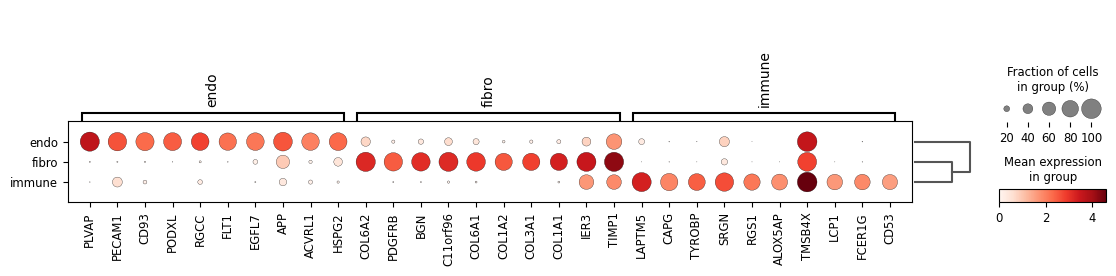

In [67]:
sc.pl.rank_genes_groups_dotplot(
    sc_baron_processed, groupby="cell_type", key="wilcoxon_cell_type", 
)

In [40]:
# get marker genes
marker_pen = {}
marker_baron = {}
marker_raghavan = {}

for celltype in sc_pen_processed.obs.cell_type.unique() :
    
    temp_pen = sc.get.rank_genes_groups_df(sc_pen_processed, group="immune", key="wilcoxon_cell_type")
    marker_pen[celltype] = temp_pen.loc[(temp_pen.logfoldchanges>1) & (temp_pen.pvals_adj<0.05)].names

    if celltype in sc_baron_processed.obs.cell_type.unique():
        temp_baron = sc.get.rank_genes_groups_df(sc_baron_processed, group="immune", key="wilcoxon_cell_type")
        marker_baron[celltype] = temp_baron.loc[(temp_baron.logfoldchanges>1) & (temp_baron.pvals_adj<0.05)].names

    if celltype in sc_raghavan_processed.obs.cell_type.unique():
        temp_raghavan = sc.get.rank_genes_groups_df(sc_raghavan_processed, group="immune", key="wilcoxon_cell_type")
        marker_raghavan[celltype] = temp_raghavan.loc[(temp_raghavan.logfoldchanges>1) & (temp_raghavan.pvals_adj<0.05)].names

        



In [ ]:
# Merge list per cell types
immune_marker = list(set(marker_pen["immune"].tolist() + marker_raghavan["immune"].tolist() + marker_baron["immune"].tolist()))
endo_marker = list(set(marker_pen["endo"].tolist() + marker_raghavan["endo"].tolist() + marker_baron["endo"].tolist()))
fibro_marker = list(set(marker_pen["fibro"].tolist() + marker_baron["fibro"].tolist()))
classic_marker = list(set(marker_pen["classic"].tolist() + marker_raghavan["classic"].tolist()))
basal_marker = list(set(marker_pen["basal"].tolist() + marker_raghavan["basal"].tolist()))

In [ ]:
# Create final gene list
final_markers = list(set(immune_marker + endo_marker + fibro_marker + classic_marker + basal_marker))
# Save final gene list
pandas.DataFrame(final_markers, columns=["marker_genes"]).to_csv("final_markers.csv")

In [75]:
len(classic_marker)

1446